# Importing Packages

In [1]:
import numpy as np
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.quantization
from torchvision.models.quantization import resnet18

# Loading Model and Quantizing

In [2]:
import torch
from torch.ao.quantization import get_default_qconfig_mapping
from torch.quantization.quantize_fx import prepare_fx, convert_fx

qconfig_mapping = get_default_qconfig_mapping()
# Or explicity specify the qengine
# qengine = 'x86'
# torch.backends.quantized.engine = qengine
# qconfig_mapping = get_default_qconfig_mapping(qengine)

model_fp32 = resnet18(pretrained=True).eval()
x = torch.randn((1, 3, 224, 224), dtype=torch.float)
x = x.to(memory_format=torch.channels_last)

# Insert observers according to qconfig and backend config
prepared_model = prepare_fx(model_fp32, qconfig_mapping, example_inputs=x)

# Calibration code not shown

# Convert to quantized model
quantized_model = convert_fx(prepared_model)

/home/adam-taback/Desktop/APS360/APS360_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adam-taback/Desktop/APS360/APS360_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/adam-taback/Desktop/APS360/APS360_env/lib/python3.12/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/home/adam-tab

# Functions to Get Activations

In [72]:
# Function to capture intermediate outputs and prepare for quantization
def get_intermediate_outputs(model, input_data):
    intermediate_outputs = []

    def hook_fn(module, input, output):
        intermediate_outputs.append(input)
        intermediate_outputs.append(output)

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Forward pass
    with torch.no_grad():
        model(input_data)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return intermediate_outputs

# Quantize and save all tensors
def save_tensor_as_list(tensor, filename):
    tensor_list = tensor.cpu().numpy().tolist()  # Convert tensor to list
    with open(filename, 'w') as f:
        json.dump(tensor_list, f)
        
# save tensors as numpy files
def save_tensor_as_npy(tensor, filename):
    tensor_list = tensor.cpu().numpy()  # Convert tensor to list
    np.save(filename, tensor_list)

In [73]:
class CompTensor:
    def __init__(self, tensor):
        self.tensor = tensor
        self.shape = tensor.shape
        self.flat = tensor.flatten()

    def update_tensor(self):
        # update tensor with new values from self.flatten
        self.tensor = self.flatten.reshape(self.shape)
        
    def update_flatten(self):
        # update flatten with new values from self.tensor
        self.flat = self.tensor.flatten()
        
    def to(self, type):
        self.tensor = self.tensor.to(type)
        self.update_flatten()
        
        return self

# Generate Traces

In [105]:
# Define an input tensor with appropriate shape
input_tensors = [torch.randn(1, 3, 224, 224) for i in range(9)]  # For a single image of size 224x224 with 3 channels (RGB)

# Capture intermediate outputs
intermediate_outputs = []
for data in input_tensors:
    intermediate_outputs.append(get_intermediate_outputs(quantized_model, data))
    
# group tensors by layer
layerwise_tensors = {}
for i in range(len(intermediate_outputs)):
    for j in range(len(intermediate_outputs[i])):
        if j not in layerwise_tensors:
            layerwise_tensors[j] = []
        layerwise_tensors[j].append(intermediate_outputs[i][j][0].int_repr())

# convert lists to tensors
for j in layerwise_tensors:
    layerwise_tensors[j] = torch.stack(layerwise_tensors[j])
    
# print tensors
for j in layerwise_tensors:
    print(j, layerwise_tensors[j].shape)
    
    
# Get unique values for each layer
unique_layerwise_tensors = {}
for j in layerwise_tensors:
    unique_layerwise_tensors[j] = torch.unique(layerwise_tensors[j].flatten())

print("Unique values per layer:")
for key, value in unique_layerwise_tensors.items():
    print(f"Layer {key}:")
    print(value)

0 torch.Size([9, 1, 3, 224, 224])
1 torch.Size([9, 64, 112, 112])
2 torch.Size([9, 1, 64, 112, 112])
3 torch.Size([9, 64, 56, 56])
4 torch.Size([9, 1, 512, 7, 7])
5 torch.Size([9, 512, 1, 1])
6 torch.Size([9, 1, 512])
7 torch.Size([9, 1000])
Unique values per layer:
Layer 0:
tensor([0, 1, 2, 3, 4, 5], dtype=torch.uint8)
Layer 1:
tensor([0, 1, 2, 3], dtype=torch.uint8)
Layer 2:
tensor([0, 1, 2, 3], dtype=torch.uint8)
Layer 3:
tensor([0, 1, 2, 3], dtype=torch.uint8)
Layer 4:
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18], dtype=torch.uint8)
Layer 5:
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11], dtype=torch.uint8)
Layer 6:
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11], dtype=torch.uint8)
Layer 7:
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.uint8)


In [107]:
# flatten layerwise tensors
flatten_layerwise_tensors = []

for key in layerwise_tensors:
    flatten_layerwise_tensors.append(CompTensor((layerwise_tensors[key]).flatten()))

In [108]:
# save all tensors as numpy files
d = "trace/"
for i in range(len(flatten_layerwise_tensors)):
    save_tensor_as_npy(flatten_layerwise_tensors[i].to(torch.int8).tensor, d + "input_" + str(i) + "_flat.npy")
    
for i in range(len(layerwise_tensors)):
    save_tensor_as_npy(layerwise_tensors[i].to(torch.int8), d + "input_" + str(i) + ".npy")

# Generating Symbol Tables for Traces

In [111]:
# run atalanta_numpy.py on the saved numpy files to get the symbol tables
import subprocess
import os

e_size = 8 # number of bits per element

for i in range(8):

    print("Running Atalanta on input_" + str(i) + "_flat.npy")
    
    # define file to get trace from
    trace = "trace/" + "input_" + str(i) + "_flat.npy"

    # define command
    command = ["python3", "atalanta/atalanta_numpy.py", trace, str(e_size)]
    
    # Run the command
    result = subprocess.run(command, capture_output=True, text=True)

    # Print the output and error (if any)
    # print("\tOutput:")
    # print("\t", result.stdout)

    print("\tError:")
    print("\t",result.stderr)

Running Atalanta on input_0_flat.npy
	Error:
	 PT_INIT: [0, 4 (1354752)] [16, 4 (0)] [32, 4 (0)] [48, 4 (0)] [64, 4 (0)] [80, 4 (0)] [96, 4 (0)] [112, 4 (0)] [128, 4 (0)] [144, 4 (0)] [160, 4 (0)] [176, 4 (0)] [192, 4 (0)] [208, 4 (0)] [224, 4 (0)] [240, 4 (0)] [256, 0 (0)] 
PTBEST: PT_INIT: [0, 3 (1354752)] [8, 5 (0)] [32, 4 (0)] [48, 4 (0)] [64, 4 (0)] [80, 4 (0)] [96, 4 (0)] [112, 4 (0)] [128, 4 (0)] [144, 4 (0)] [160, 4 (0)] [176, 4 (0)] [192, 4 (0)] [208, 4 (0)] [224, 4 (0)] [240, 4 (0)] [256, 0 (0)] 
PTBEST: PT_INIT: [0, 2 (1354428)] [4, 5 (324)] [32, 4 (0)] [48, 4 (0)] [64, 4 (0)] [80, 4 (0)] [96, 4 (0)] [112, 4 (0)] [128, 4 (0)] [144, 4 (0)] [160, 4 (0)] [176, 4 (0)] [192, 4 (0)] [208, 4 (0)] [224, 4 (0)] [240, 4 (0)] [256, 0 (0)] 
PTBEST: PT_INIT: [0, 1 (1264065)] [2, 5 (90687)] [32, 4 (0)] [48, 4 (0)] [64, 4 (0)] [80, 4 (0)] [96, 4 (0)] [112, 4 (0)] [128, 4 (0)] [144, 4 (0)] [160, 4 (0)] [176, 4 (0)] [192, 4 (0)] [208, 4 (0)] [224, 4 (0)] [240, 4 (0)] [256, 0 (0)] 

Running A

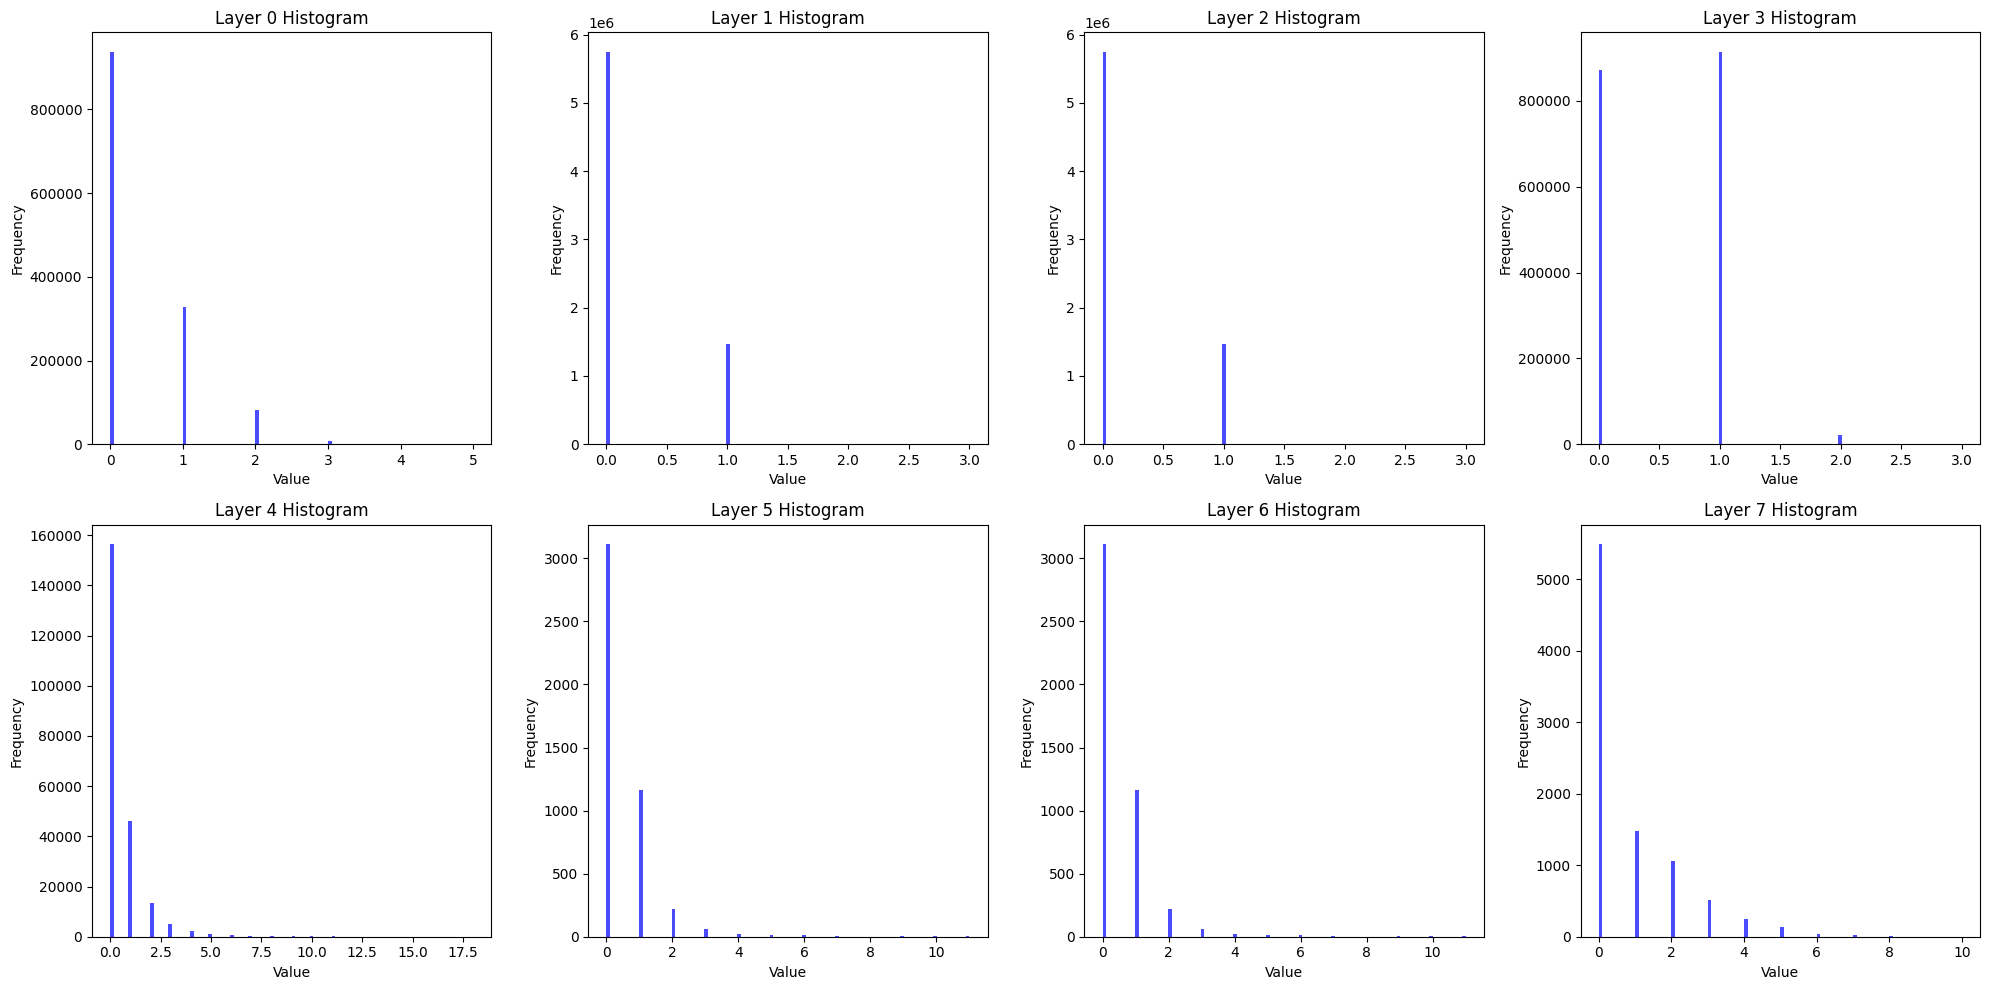

In [119]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows and 4 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each layer
for i in range(8):
    temp = flatten_layerwise_tensors[i]
    
    # Plot temp as histogram
    axes[i].hist(temp.flat.cpu().numpy(), bins=100, color='blue', alpha=0.7)
    axes[i].set_title(f"Layer {i} Histogram")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Generating Symbol Table

In [112]:
# Take the first tensor and prep the symbols
inp = all_tensors[2]

# get a histogram of the tensor
n_buckets = 2**8
hist, bin_edges = np.histogram(inp.flat, bins=n_buckets)

# plot the histogram
import matplotlib.pyplot as plt
plt.plot(hist)
plt.show()

NameError: name 'all_tensors' is not defined

In [51]:
# Create symbol table with equal distribution
n_symbols = 2**8

sym_table = np.linspace(min(inp.flat), max(inp.flat), n_symbols)
sym_table = np.column_stack((sym_table,hist))

In [52]:
sym_table

array([[-4.47050238e+00,  1.00000000e+00],
       [-4.43382203e+00,  0.00000000e+00],
       [-4.39714168e+00,  0.00000000e+00],
       [-4.36046134e+00,  0.00000000e+00],
       [-4.32378099e+00,  0.00000000e+00],
       [-4.28710064e+00,  0.00000000e+00],
       [-4.25042030e+00,  0.00000000e+00],
       [-4.21373995e+00,  1.00000000e+00],
       [-4.17705960e+00,  0.00000000e+00],
       [-4.14037925e+00,  0.00000000e+00],
       [-4.10369891e+00,  1.00000000e+00],
       [-4.06701856e+00,  1.00000000e+00],
       [-4.03033821e+00,  0.00000000e+00],
       [-3.99365787e+00,  2.00000000e+00],
       [-3.95697752e+00,  0.00000000e+00],
       [-3.92029717e+00,  0.00000000e+00],
       [-3.88361683e+00,  0.00000000e+00],
       [-3.84693648e+00,  0.00000000e+00],
       [-3.81025613e+00,  1.00000000e+00],
       [-3.77357579e+00,  2.00000000e+00],
       [-3.73689544e+00,  1.00000000e+00],
       [-3.70021509e+00,  2.00000000e+00],
       [-3.66353475e+00,  4.00000000e+00],
       [-3.

In [53]:
from scipy.stats import entropy
# calculate current size of table using entropy
def calculate_entropy(data):
    """
    Calculate the entropy of a dataset.
    
    Parameters:
        data (list or np.array or pd.Series): The input data (categorical or discrete values).
    
    Returns:
        float: The calculated entropy.
    """
    if isinstance(data, pd.Series):
        value_counts = data.value_counts(normalize=True)
    else:
        value_counts = pd.Series(data).value_counts(normalize=True)
    
    return entropy(value_counts)

In [54]:
# go through each bin, and calculate the entropy
entropies = []
for i in range(n_buckets):
    # get the indices of the data that are in the bin
    indices = np.where((inp.flat >= bin_edges[i]) & (inp.flat < bin_edges[i+1]))[0]
    
    # calculate the entropy of the data in the bin
    entropies.append(calculate_entropy(inp.flat[indices]))

In [55]:
sum(entropies)/(2**8)

4.3160160143724955